<a href="https://colab.research.google.com/github/Manasa2389/animals10-classification-cam/blob/main/animals10_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!ls /root/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory
kaggle.json


In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 95% 555M/586M [00:01<00:00, 331MB/s]
100% 586M/586M [00:01<00:00, 415MB/s]


In [ ]:
1!unzip animals10.zip -d animals10_data

Streaming output truncated to the last 5000 lines.
  inflating: animals10_data/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQH

In [ ]:
!ls animals10_data

raw-img  translate.py


In [ ]:
!ls animals10_data/raw-img

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_dir = "/content/animals10_data/raw-img"   # same path

# image transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# full dataset (Italian folder names)
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

print("Italian class folders:", full_dataset.classes)

# Italian → English mapping
it_to_en = {
    "cane": "dog",
    "gatto": "cat",
    "cavallo": "horse",
    "elefante": "elephant",
    "gallina": "chicken",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "farfalla": "butterfly",
    "scoiattolo": "squirrel"
}

class_names_it = full_dataset.classes
class_names_en = [it_to_en[c] for c in class_names_it]
print("English class names:", class_names_en)

# train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# val dataset ki transforms marchadam
val_dataset.dataset.transform = val_transforms

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

# ---------- MODEL PART ----------
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# freeze backbone
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names_en))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

print("Model ready ✅")

Using device: cuda
Italian class folders: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
English class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Train samples: 20943
Val samples: 5236
Model ready ✅


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


num_epochs = 3

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_model(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

torch.save(model.state_dict(), "animals10_resnet18.pth")
print("Model saved ✅")

Epoch 1/5 | Train Loss: 0.2502, Acc: 0.9313 | Val Loss: 0.1650, Acc: 0.9463
Epoch 2/5 | Train Loss: 0.1837, Acc: 0.9447 | Val Loss: 0.1413, Acc: 0.9509
Epoch 3/5 | Train Loss: 0.1675, Acc: 0.9466 | Val Loss: 0.1517, Acc: 0.9488


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch

In [ ]:
# Forward hook to capture last conv feature maps
features = None

def forward_hook(module, inp, out):
    global features
    features = out.detach()

# attach hook to last conv block output
handle = model.layer4.register_forward_hook(forward_hook)

print("CAM forward hook registered ✅")

CAM forward hook registered ✅


In [ ]:
def generate_cam(image_tensor):
    model.eval()

    # [1, 3, 224, 224]
    x = image_tensor.unsqueeze(0).to(device)

    # Forward pass (hook will fill `features`)
    with torch.no_grad():
        output = model(x)
        probs = torch.softmax(output, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        confidence = probs[0, pred_idx].item()

    # Feature maps from last conv block: [1, C, H, W]
    global features
    fmap = features[0]          # [C, H, W]
    fmap_np = fmap.cpu().numpy()

    # FC layer weights: [num_classes, C]
    fc_weights = list(model.fc.parameters())[0].detach().cpu().numpy()

    # Weights for predicted class: [C]
    w = fc_weights[pred_idx]

    # Class Activation Map = Σ w_k * A_k
    cam = np.zeros((fmap_np.shape[1], fmap_np.shape[2]), dtype=np.float32)
    for k, w_k in enumerate(w):
        cam += w_k * fmap_np[k]

    # Normalize [0,1]
    cam = np.maximum(cam, 0)
    cam -= cam.min()
    if cam.max() > 0:
        cam /= cam.max()

    return cam, pred_idx, confidence

In [ ]:
# undo normalization for showing image
denorm = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225],
)

def show_cam_on_val(index=0):
    # val_dataset nunchi okka sample
    img, label = val_dataset[index]   # [3,224,224]

    # heatmap compute
    cam, pred_idx, conf = generate_cam(img.clone())

    # original image [0,1] range, HWC format
    img_denorm = denorm(img).permute(1, 2, 0).cpu().numpy()
    img_denorm = np.clip(img_denorm, 0, 1)

    plt.figure(figsize=(8, 4))

    # LEFT: original
    plt.subplot(1, 2, 1)
    plt.imshow(img_denorm)
    plt.axis('off')
    plt.title(f"Original\nTrue: {class_names_en[label]}")

    # RIGHT: CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(img_denorm)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"CAM\nPred: {class_names_en[pred_idx]} ({conf*100:.1f}%)")

    plt.tight_layout()
    plt.show()

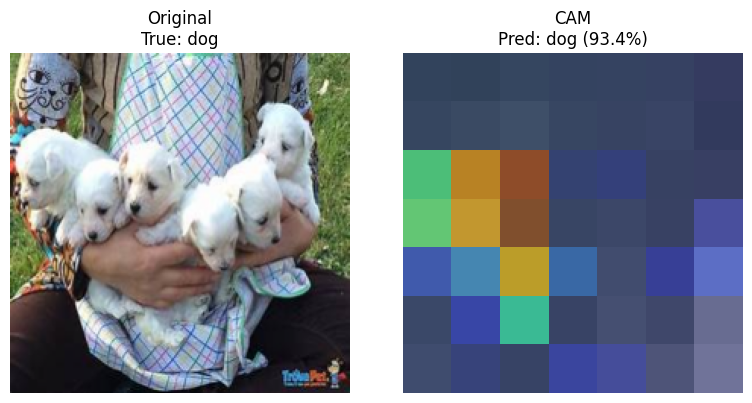

In [ ]:
show_cam_on_val(0)

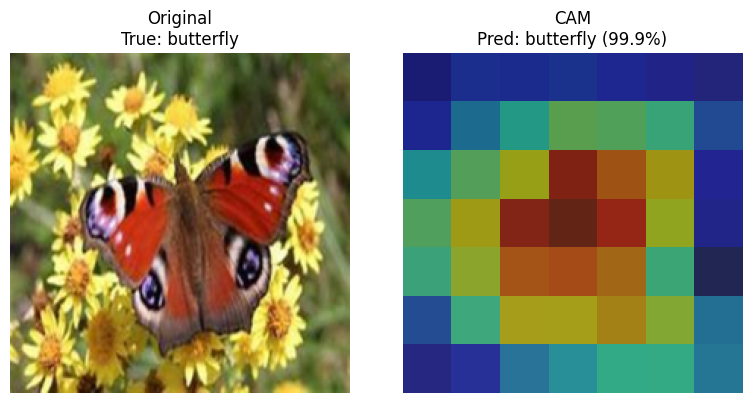

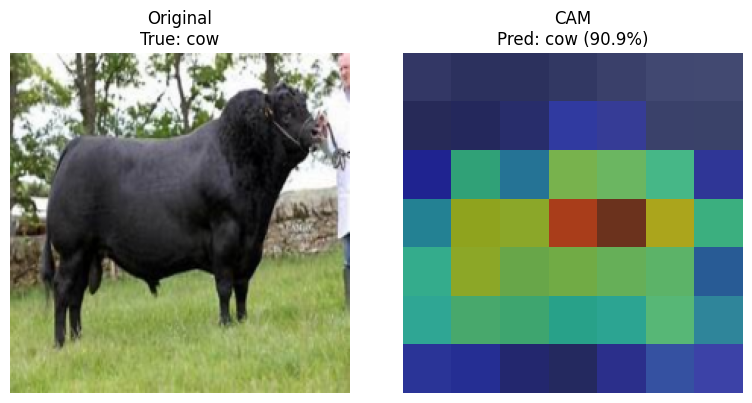

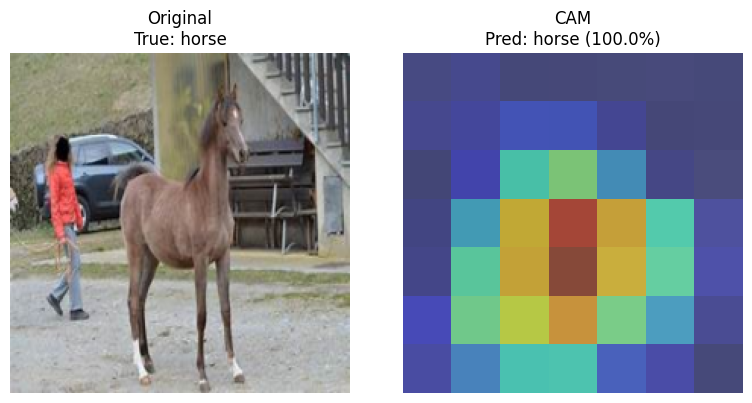

In [ ]:
show_cam_on_val(5)
show_cam_on_val(10)
show_cam_on_val(20)